## Importing Libraries

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/convolve-train-data/Dev_data_to_be_shared.csv


In [15]:

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, log_loss, roc_auc_score, precision_recall_curve, auc

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
#i need to do exploratory datanalysis
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Reading Data

In [6]:
df = pd.read_csv('/kaggle/input/convolve-train-data/Dev_data_to_be_shared.csv')

In [7]:
df.head()

,account_number,bad_flag,onus_attribute_1,transaction_attribute_1,transaction_attribute_2,transaction_attribute_3,transaction_attribute_4,transaction_attribute_5,transaction_attribute_6,transaction_attribute_7,...,bureau_enquiry_47,bureau_enquiry_48,bureau_enquiry_49,bureau_enquiry_50,onus_attribute_43,onus_attribute_44,onus_attribute_45,onus_attribute_46,onus_attribute_47,onus_attribute_48
0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0,221000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,25000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0,86000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0,215000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.info(max_cols=1220, show_counts=True)
# Most of the data is of float64 memory type.Will downsize it wherever possible to save computation resources.

## Memory Optimization

In [8]:
def optimize_dataframe(df):
    """
    Downsize numeric columns in the DataFrame to minimize memory usage without losing accuracy.
    NaN values are preserved during the conversion.
    """
    optimized_df = df.copy()
    
    for col in optimized_df.select_dtypes(include=['int64', 'float64']).columns:
        col_data = optimized_df[col]
        
        if pd.api.types.is_integer_dtype(col_data) or np.all(col_data.dropna() == col_data.dropna().astype(int)):
            # If the column is integer or float but can safely be cast to integer
            if col_data.min() >= np.iinfo(np.int8).min and col_data.max() <= np.iinfo(np.int8).max:
                optimized_df[col] = col_data.astype('Int8')  # Nullable integer type
            elif col_data.min() >= np.iinfo(np.int16).min and col_data.max() <= np.iinfo(np.int16).max:
                optimized_df[col] = col_data.astype('Int16')  # Nullable integer type
            elif col_data.min() >= np.iinfo(np.int32).min and col_data.max() <= np.iinfo(np.int32).max:
                optimized_df[col] = col_data.astype('Int32')  # Nullable integer type
            else:
                optimized_df[col] = col_data.astype('Int64')  # Nullable integer type
        else:
            # For floats, determine the smallest float dtype
            if col_data.min() >= np.finfo(np.float32).min and col_data.max() <= np.finfo(np.float32).max:
                optimized_df[col] = col_data.astype('float32')
            else:
                optimized_df[col] = col_data.astype('float64')
    
    return optimized_df


df = optimize_dataframe(df)

In [10]:
df_c = df
# Creating a copy

## Distribution of the bad_flag in the dataset (Imbalanced Data)

Distribution of the bad_flag in the dataset
bad_flag
0    0.985827
1    0.014173
Name: count, dtype: Float64


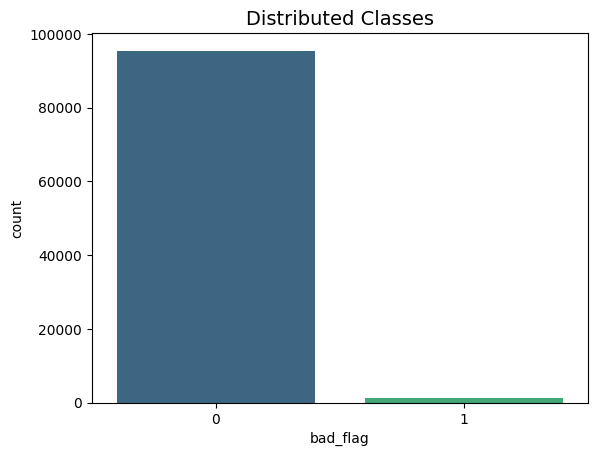

In [9]:
print('Distribution of the bad_flag in the dataset')
print(df['bad_flag'].value_counts()/len(df))

sns.countplot(x='bad_flag', data=df, palette='viridis')
plt.title('Distributed Classes', fontsize=14)
plt.show()
# The Dataset is Highly Imbalanced

## Exploratory Data Analysis (EDA)

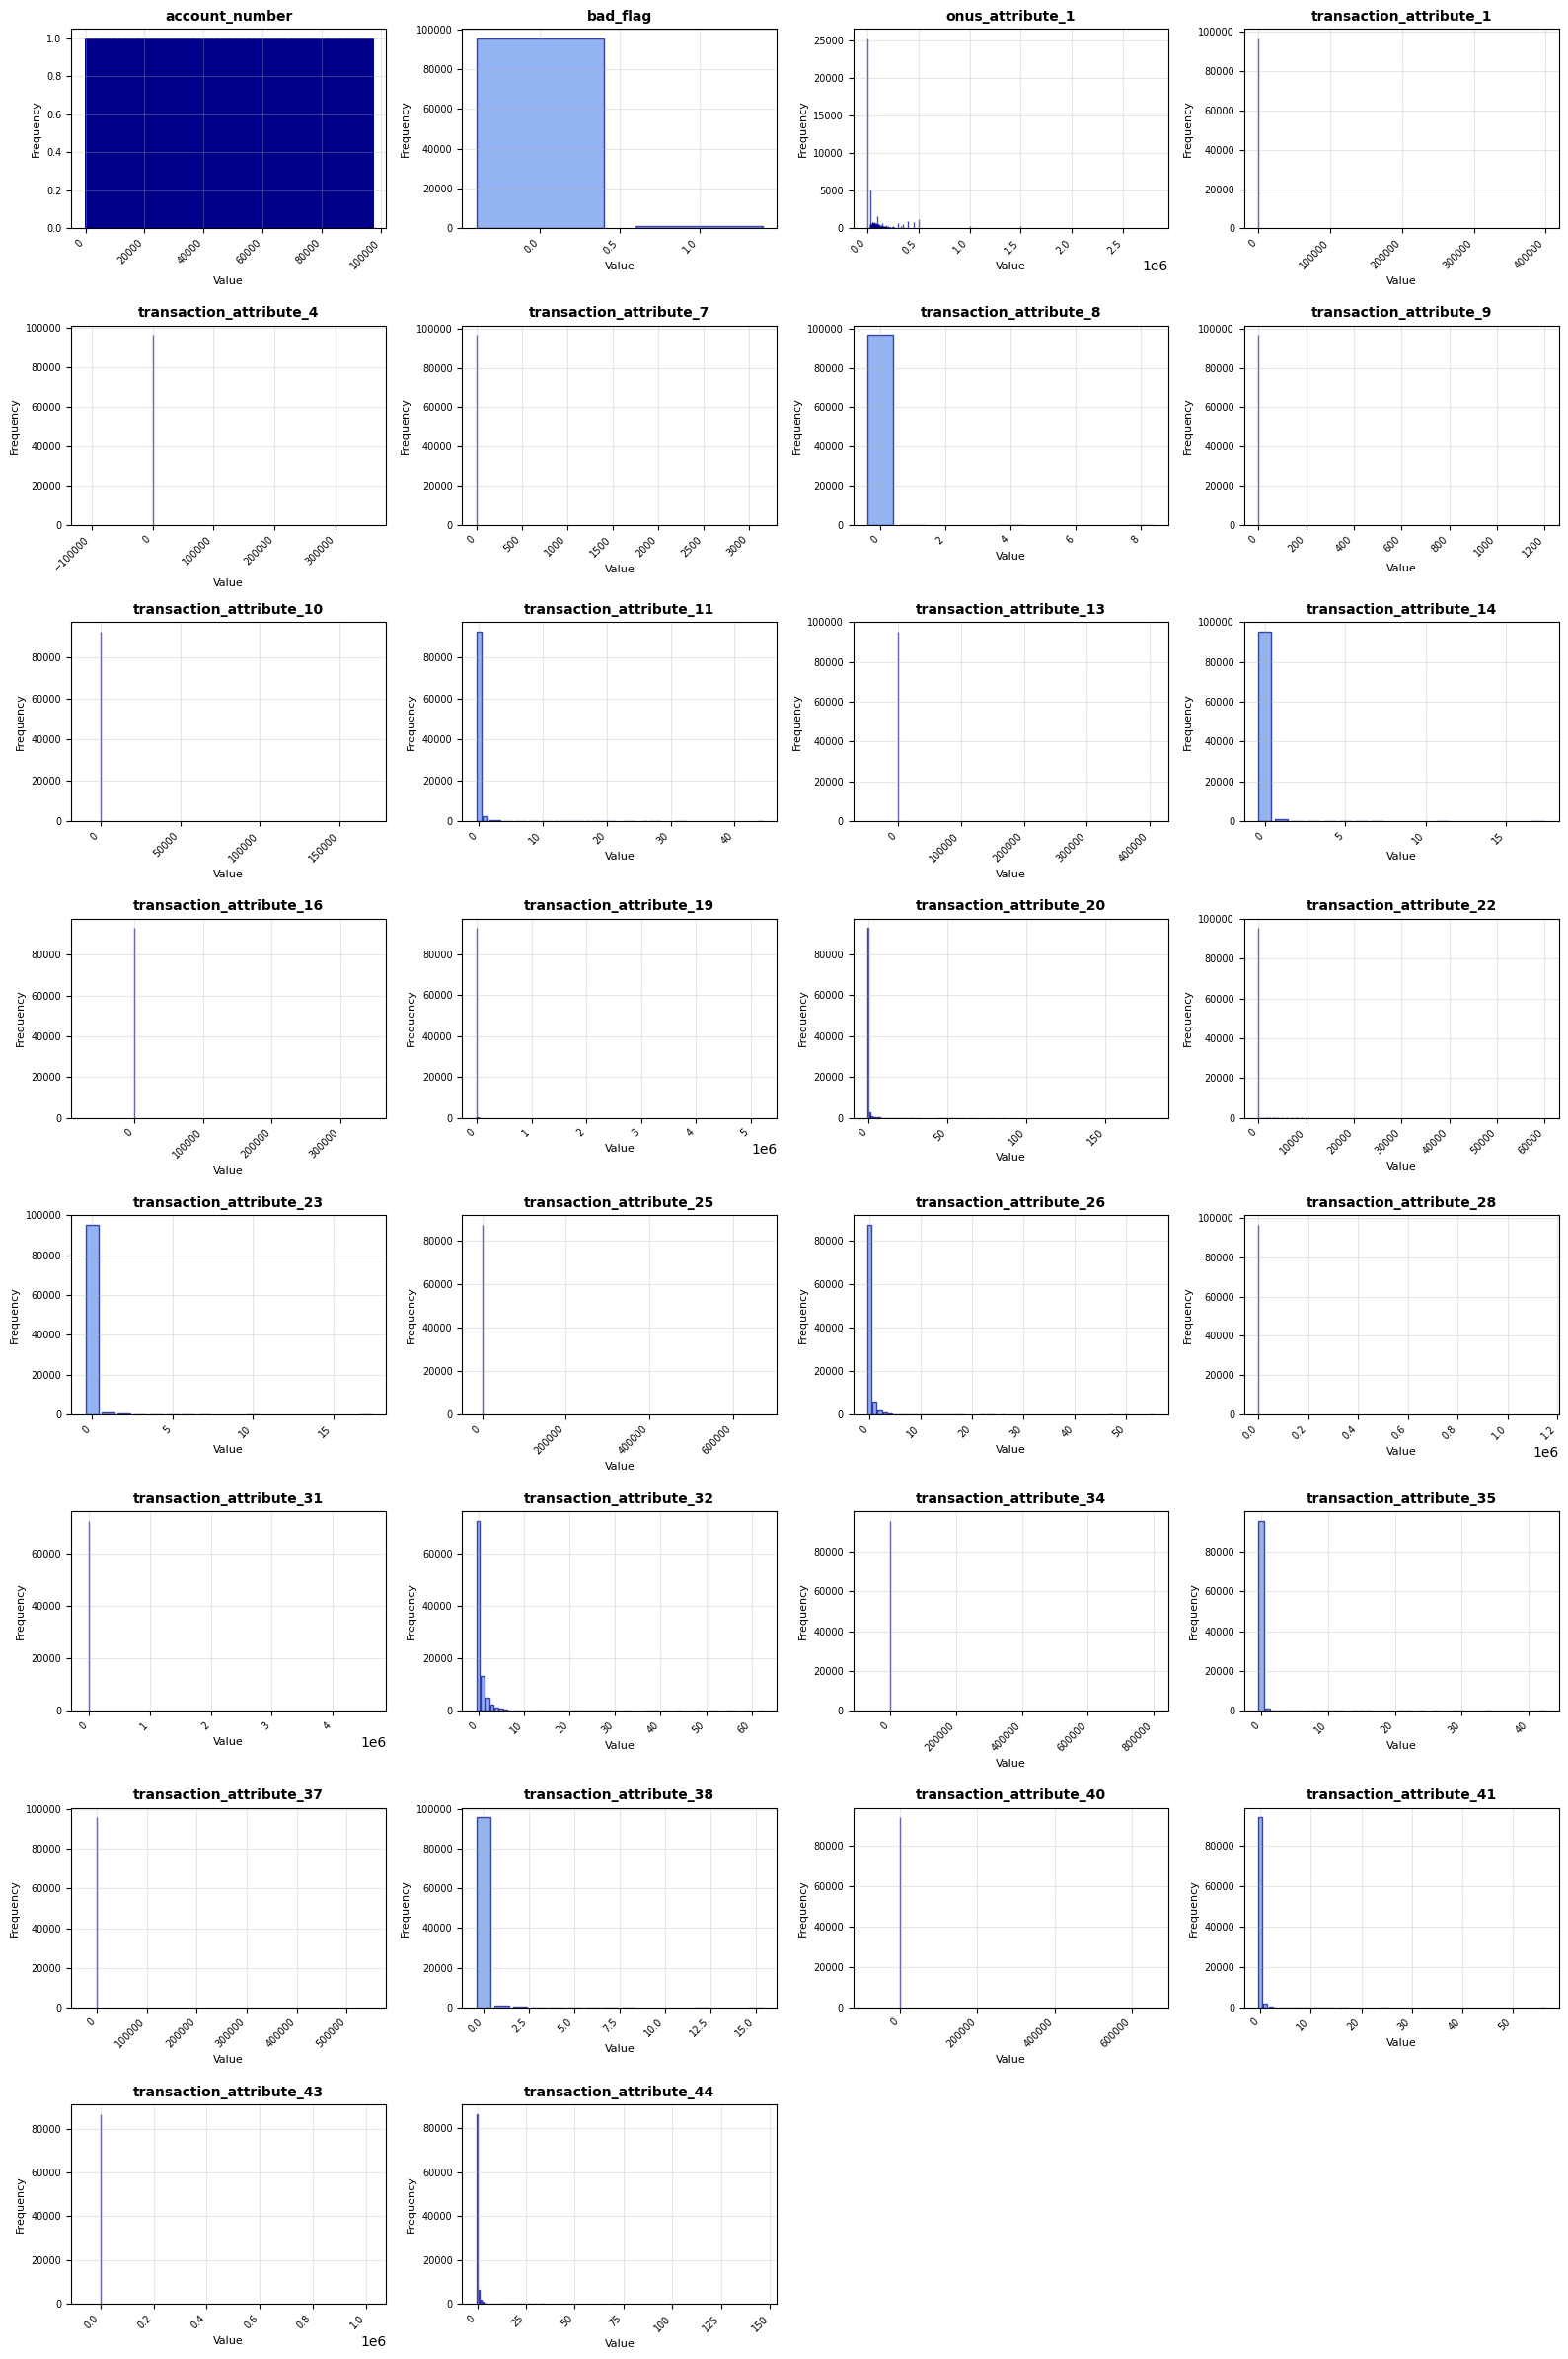

In [86]:
import matplotlib.pyplot as plt

# Select the first 30 columns from the DataFrame
features_to_plot = df.columns[:30]

# Number of plots per row
ncols = 4  
nrows = (len(features_to_plot) + ncols - 1) // ncols  # Calculate required rows

# Set plot size
plt.figure(figsize=(ncols * 4, nrows * 3))

# Create bar plots for the first 30 features
for i, col in enumerate(features_to_plot):
    plt.subplot(nrows, ncols, i + 1)
    value_counts = df[col].value_counts().sort_index()  # Get frequency of each value
    plt.bar(value_counts.index, value_counts.values, color='cornflowerblue', edgecolor='darkblue', alpha=0.7)
    plt.title(col, fontsize=10, fontweight='bold')
    plt.xlabel('Value', fontsize=8)
    plt.ylabel('Frequency', fontsize=8)
    plt.xticks(rotation=45, ha='right', fontsize=7)  # Rotate x-axis labels for readability
    plt.yticks(fontsize=7)
    plt.grid(True, linestyle='-', alpha=0.3)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [11]:
onus_wale=[]
for _ in df.columns:
  if 'onus' in _:
    onus_wale.append(_)
print(onus_wale)

['onus_attribute_1', 'onus_attribute_2', 'onus_attribute_3', 'onus_attribute_4', 'onus_attribute_5', 'onus_attribute_6', 'onus_attribute_7', 'onus_attribute_8', 'onus_attribute_9', 'onus_attribute_10', 'onus_attribute_11', 'onus_attribute_12', 'onus_attribute_13', 'onus_attribute_14', 'onus_attribute_15', 'onus_attribute_16', 'onus_attribute_17', 'onus_attribute_18', 'onus_attribute_19', 'onus_attribute_20', 'onus_attribute_21', 'onus_attribute_22', 'onus_attribute_23', 'onus_attribute_24', 'onus_attribute_25', 'onus_attribute_26', 'onus_attribute_27', 'onus_attribute_28', 'onus_attribute_29', 'onus_attribute_30', 'onus_attribute_31', 'onus_attribute_32', 'onus_attribute_33', 'onus_attribute_34', 'onus_attribute_35', 'onus_attribute_36', 'onus_attribute_37', 'onus_attribute_38', 'onus_attribute_39', 'onus_attribute_40', 'onus_attribute_41', 'onus_attribute_42', 'onus_attribute_43', 'onus_attribute_44', 'onus_attribute_45', 'onus_attribute_46', 'onus_attribute_47', 'onus_attribute_48']


In [12]:
og_df=df.copy()
count_1s = df[df['bad_flag'] == 1].shape[0]
print(f"Total number of rows with 1s: {count_1s}")

# Filter rows with 1s and 0s
df_1s = df[df['bad_flag'] == 1]
df_0s = df[df['bad_flag'] == 0]

# Sample equal number of rows with 0s
df_0s_balanced = df_0s.sample(n=count_1s, random_state=42)

# Concatenate the balanced DataFrame
df_balanced = pd.concat([df_1s, df_0s_balanced])

# Shuffle the rows for randomness
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
print(df_balanced.value_counts('bad_flag'))

Total number of rows with 1s: 1372
bad_flag
0    1372
1    1372
Name: count, dtype: int64


In [13]:
df= df_balanced.copy()

In [14]:
corr=df.corr()
# sns.heatmap(corr,annot=True,cmap='coolwarm')
# plt.title('Feature Heatmap')
# plt.show()

In [16]:
for col in onus_wale:
    nan_count = df[col].isna().sum()
    if nan_count > 0:
        df[col].fillna(999, inplace=True)

In [17]:
beaureu_wale=[]
for _ in df.columns:
  if 'bureau' in _:
    beaureu_wale.append(_)
print(beaureu_wale)

['bureau_1', 'bureau_2', 'bureau_3', 'bureau_4', 'bureau_5', 'bureau_6', 'bureau_7', 'bureau_8', 'bureau_9', 'bureau_10', 'bureau_11', 'bureau_12', 'bureau_13', 'bureau_14', 'bureau_15', 'bureau_16', 'bureau_17', 'bureau_18', 'bureau_19', 'bureau_20', 'bureau_21', 'bureau_22', 'bureau_23', 'bureau_24', 'bureau_25', 'bureau_26', 'bureau_27', 'bureau_28', 'bureau_29', 'bureau_30', 'bureau_31', 'bureau_32', 'bureau_33', 'bureau_34', 'bureau_35', 'bureau_36', 'bureau_37', 'bureau_38', 'bureau_39', 'bureau_40', 'bureau_41', 'bureau_42', 'bureau_43', 'bureau_44', 'bureau_45', 'bureau_46', 'bureau_47', 'bureau_48', 'bureau_49', 'bureau_50', 'bureau_51', 'bureau_52', 'bureau_53', 'bureau_54', 'bureau_55', 'bureau_56', 'bureau_57', 'bureau_58', 'bureau_59', 'bureau_60', 'bureau_61', 'bureau_62', 'bureau_63', 'bureau_64', 'bureau_65', 'bureau_66', 'bureau_67', 'bureau_68', 'bureau_69', 'bureau_70', 'bureau_71', 'bureau_72', 'bureau_73', 'bureau_74', 'bureau_75', 'bureau_76', 'bureau_77', 'bureau

In [18]:
for col in beaureu_wale:
    nan_count = df[col].isna().sum()
    if nan_count > 0:
        df[col].fillna(999, inplace=True)

In [19]:
trans_wale= []
for _ in df.columns:
  if 'trans' in _:
    trans_wale.append(_)
print(trans_wale)

['transaction_attribute_1', 'transaction_attribute_2', 'transaction_attribute_3', 'transaction_attribute_4', 'transaction_attribute_5', 'transaction_attribute_6', 'transaction_attribute_7', 'transaction_attribute_8', 'transaction_attribute_9', 'transaction_attribute_10', 'transaction_attribute_11', 'transaction_attribute_12', 'transaction_attribute_13', 'transaction_attribute_14', 'transaction_attribute_15', 'transaction_attribute_16', 'transaction_attribute_17', 'transaction_attribute_18', 'transaction_attribute_19', 'transaction_attribute_20', 'transaction_attribute_21', 'transaction_attribute_22', 'transaction_attribute_23', 'transaction_attribute_24', 'transaction_attribute_25', 'transaction_attribute_26', 'transaction_attribute_27', 'transaction_attribute_28', 'transaction_attribute_29', 'transaction_attribute_30', 'transaction_attribute_31', 'transaction_attribute_32', 'transaction_attribute_33', 'transaction_attribute_34', 'transaction_attribute_35', 'transaction_attribute_36', 

In [20]:
trans_df=df[trans_wale]

In [21]:
corr_1=trans_df.corr()
corr_1

,transaction_attribute_1,transaction_attribute_2,transaction_attribute_3,transaction_attribute_4,transaction_attribute_5,transaction_attribute_6,transaction_attribute_7,transaction_attribute_8,transaction_attribute_9,transaction_attribute_10,...,transaction_attribute_655,transaction_attribute_656,transaction_attribute_657,transaction_attribute_658,transaction_attribute_659,transaction_attribute_660,transaction_attribute_661,transaction_attribute_662,transaction_attribute_663,transaction_attribute_664
transaction_attribute_1,1.000000,0.989940,1.000000,-0.000806,-0.001118,-0.000887,NaN,NaN,NaN,-0.002685,...,-0.005353,-0.001809,-0.009222,-0.011109,0.023019,0.022778,-0.015431,-0.000789,0.001785,-0.001673
transaction_attribute_2,0.989940,1.000000,0.989940,-0.000814,-0.001129,-0.000896,NaN,NaN,NaN,-0.002712,...,-0.005088,-0.001576,-0.009294,-0.010955,0.018524,0.018278,-0.014491,-0.000797,0.002205,-0.001690
transaction_attribute_3,1.000000,0.989940,1.000000,-0.000806,-0.001118,-0.000887,NaN,NaN,NaN,-0.002685,...,-0.005353,-0.001809,-0.009222,-0.011109,0.023019,0.022778,-0.015431,-0.000789,0.001785,-0.001673
transaction_attribute_4,-0.000806,-0.000814,-0.000806,1.000000,0.882303,0.988475,NaN,NaN,NaN,-0.002259,...,-0.005424,-0.002776,-0.007874,-0.010343,-0.006762,-0.006978,0.007173,-0.000648,-0.005615,-0.001374
transaction_attribute_5,-0.001118,-0.001129,-0.001118,0.882303,1.000000,0.914354,NaN,NaN,NaN,-0.003132,...,0.013339,-0.003829,-0.010904,-0.014051,-0.010372,-0.010671,-0.000477,-0.000396,0.007442,-0.000857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
transaction_attribute_660,0.022778,0.018278,0.022778,-0.006978,-0.010671,-0.008411,NaN,NaN,NaN,-0.009125,...,0.200925,0.102742,0.279103,0.232685,0.999296,1.000000,0.587471,0.129370,0.165735,0.132164
transaction_attribute_661,-0.015431,-0.014491,-0.015431,0.007173,-0.000477,0.005742,NaN,NaN,NaN,-0.031945,...,0.051703,0.058423,0.249894,0.474543,0.589819,0.587471,1.000000,0.136745,-0.056895,0.153936
transaction_attribute_662,-0.000789,-0.000797,-0.000789,-0.000648,-0.000396,-0.000701,NaN,NaN,NaN,-0.002119,...,-0.001985,-0.002615,-0.005207,-0.010047,0.129516,0.129370,0.136745,1.000000,0.003978,0.879253
transaction_attribute_663,0.001785,0.002205,0.001785,-0.005615,0.007442,-0.005828,NaN,NaN,NaN,0.003556,...,0.204406,-0.014175,-0.034185,-0.025091,0.164984,0.165735,-0.056895,0.003978,1.000000,-0.001088


In [22]:
threshold=0.4
max_nan_count=threshold*df.shape[1]
df=df[df.isna().sum(axis=1)<=max_nan_count].reset_index(drop=True)
print(df.shape)

(2048, 1216)


In [23]:
corr=corr_1.abs()
upper=np.triu(np.ones(corr.shape),k=1).astype(bool)
to_drop=[corr.columns[j] for i in range(corr.shape[0]) for j in range(i+1,corr.shape[1]) if corr.iloc[i,j]>0.7]
df_filtered=df.drop(columns=to_drop)
df= df_filtered.copy()

In [24]:
counter=0
for _ in df.columns:
  if 'trans' in _:
    counter+=1
print(counter)

153


In [25]:
empty_Still=0
for _ in df.columns:
  if df[_].isna().sum()>0:
    print(_)
    print(df[_].isna().sum())
    df[_].fillna(0,inplace=True)
    print(df[_].isna().sum())
    empty_Still+=1
print(empty_Still)

transaction_attribute_120
6
0
transaction_attribute_121
6
0
transaction_attribute_124
6
0
transaction_attribute_125
6
0
transaction_attribute_126
6
0
transaction_attribute_128
6
0
transaction_attribute_130
6
0
transaction_attribute_131
6
0
transaction_attribute_132
6
0
transaction_attribute_133
6
0
transaction_attribute_134
6
0
transaction_attribute_135
6
0
transaction_attribute_136
6
0
transaction_attribute_138
6
0
transaction_attribute_140
6
0
transaction_attribute_142
6
0
transaction_attribute_143
6
0
transaction_attribute_144
6
0
transaction_attribute_145
6
0
transaction_attribute_146
6
0
transaction_attribute_147
6
0
transaction_attribute_148
6
0
transaction_attribute_149
6
0
transaction_attribute_150
6
0
transaction_attribute_152
6
0
transaction_attribute_153
6
0
transaction_attribute_154
6
0
transaction_attribute_155
6
0
transaction_attribute_156
6
0
transaction_attribute_364
2
0
transaction_attribute_369
2
0
transaction_attribute_454
2
0
transaction_attribute_464
2
0
transactio

## Feature Engineering

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
def process_df(df):
 thresholds=[0.75,0.8,0.85]
 for threshold in thresholds:
  corr=df.corr().abs()
  upper=corr.where(np.triu(np.ones(corr.shape),k=1).astype(bool))
  to_drop=[column for column in upper.columns if any(upper[column]>threshold)]
  df_reduced=df.drop(columns=to_drop)
  mi_scores=mutual_info_classif(df_reduced.drop(columns='bad_flag'),df['bad_flag'],discrete_features=False)
  mi_series=pd.Series(mi_scores,index=df_reduced.drop(columns='bad_flag').columns).sort_values(ascending=False)
  df_mi=df_reduced[mi_series.index[:100]]
  pca=PCA(n_components=100)
  pca.fit(df_mi)
  explained_variance=pca.explained_variance_ratio_.cumsum()
  n_components_95=np.argmax(explained_variance>=0.95)+1
  n_components_99=np.argmax(explained_variance>=0.99)+1
  print(f"Threshold:{threshold}")
  print(f"Components for 95% variance:{n_components_95}")
  print(f"Components for 99% variance:{n_components_99}")
  print(f"Features for 95% variance:{df_mi.columns[:n_components_95].tolist()}")
  print(f"Features for 99% variance:{df_mi.columns[:n_components_99].tolist()}")
  print("-"*50)
  plt.plot(range(1,len(explained_variance)+1),explained_variance,label=f'Threshold {threshold}')
 plt.xlabel('Number of Components')
 plt.ylabel('Cumulative Explained Variance')
 plt.legend()
 plt.show()

Threshold:0.75
Components for 95% variance:3
Components for 99% variance:5
Features for 95% variance:['bureau_439', 'onus_attribute_2', 'bureau_36']
Features for 99% variance:['bureau_439', 'onus_attribute_2', 'bureau_36', 'bureau_441', 'onus_attribute_26']
--------------------------------------------------
Threshold:0.8
Components for 95% variance:3
Components for 99% variance:5
Features for 95% variance:['bureau_439', 'onus_attribute_2', 'bureau_2']
Features for 99% variance:['bureau_439', 'onus_attribute_2', 'bureau_2', 'onus_attribute_29', 'bureau_441']
--------------------------------------------------
Threshold:0.85
Components for 95% variance:3
Components for 99% variance:4
Features for 95% variance:['onus_attribute_2', 'bureau_439', 'bureau_441']
Features for 99% variance:['onus_attribute_2', 'bureau_439', 'bureau_441', 'bureau_36']
--------------------------------------------------


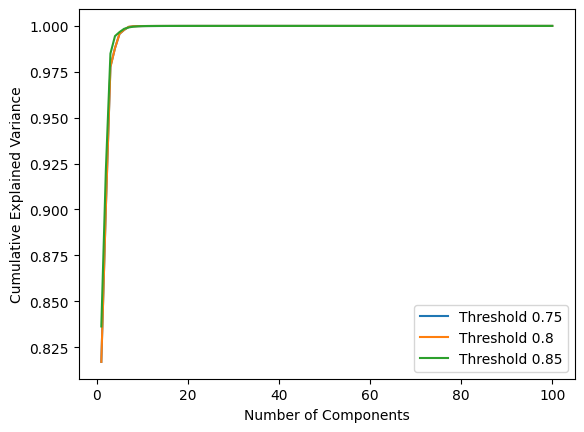

In [27]:
process_df(df)

In [28]:
df.head()

,account_number,bad_flag,onus_attribute_1,transaction_attribute_1,transaction_attribute_4,transaction_attribute_7,transaction_attribute_8,transaction_attribute_9,transaction_attribute_10,transaction_attribute_11,...,bureau_enquiry_47,bureau_enquiry_48,bureau_enquiry_49,bureau_enquiry_50,onus_attribute_43,onus_attribute_44,onus_attribute_45,onus_attribute_46,onus_attribute_47,onus_attribute_48
0,60451,1,100000,0.0,0.0,0,0,0,0.0,0,...,0,0,0,7,-25,-25,-25,-25,-25,-25
1,14581,0,107000,0.0,0.0,0,0,0,0.0,0,...,0,0,0,1,-25,-25,-25,-25,-25,-25
2,93483,1,25000,0.0,0.0,0,0,0,0.0,0,...,0,0,0,0,1,1,1,1,0,0
3,95196,1,53000,0.0,0.0,0,0,0,0.0,0,...,0,0,0,8,-25,-25,-25,-25,-25,-25
4,5726,0,30000,0.0,0.0,0,0,0,0.0,0,...,0,1,0,4,-25,-25,-25,-25,-25,-25


In [29]:
# Keep only the columns in df_c that are also in df
df_c = df_c[df_c.columns.intersection(df.columns)]

In [30]:
df=df_c

In [31]:
df

,account_number,bad_flag,onus_attribute_1,transaction_attribute_1,transaction_attribute_4,transaction_attribute_7,transaction_attribute_8,transaction_attribute_9,transaction_attribute_10,transaction_attribute_11,...,bureau_enquiry_47,bureau_enquiry_48,bureau_enquiry_49,bureau_enquiry_50,onus_attribute_43,onus_attribute_44,onus_attribute_45,onus_attribute_46,onus_attribute_47,onus_attribute_48
0,1,0,<NA>,NaN,NaN,<NA>,<NA>,<NA>,NaN,<NA>,...,0,0,0,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,2,0,221000,0.0,0.0,0,0,0,0.0,0,...,0,0,2,3,0,0,0,0,0,0
2,3,0,25000,0.0,0.0,0,0,0,0.0,0,...,0,0,0,8,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,4,0,86000,0.0,0.0,0,0,0,0.0,0,...,0,0,0,30,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,5,0,215000,0.0,0.0,0,0,0,0.0,0,...,0,0,0,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96801,96802,0,156000,0.0,0.0,0,0,0,0.0,0,...,0,0,0,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
96802,96803,0,46000,0.0,0.0,0,0,0,0.0,0,...,0,0,0,3,0,1,0,1,0,0
96803,96804,0,95000,0.0,0.0,0,0,0,0.0,0,...,0,0,0,20,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
96804,96805,0,88000,0.0,0.0,0,0,0,0.0,0,...,0,1,0,8,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [32]:
onus_wale=[]
for _ in df.columns:
  if 'onus' in _:
    onus_wale.append(_)
print(onus_wale)
for col in onus_wale:
    nan_count = df[col].isna().sum()
    if nan_count > 0:
        df[col].fillna(999, inplace=True)

['onus_attribute_1', 'onus_attribute_2', 'onus_attribute_3', 'onus_attribute_4', 'onus_attribute_5', 'onus_attribute_6', 'onus_attribute_7', 'onus_attribute_8', 'onus_attribute_9', 'onus_attribute_10', 'onus_attribute_11', 'onus_attribute_12', 'onus_attribute_13', 'onus_attribute_14', 'onus_attribute_15', 'onus_attribute_16', 'onus_attribute_17', 'onus_attribute_18', 'onus_attribute_19', 'onus_attribute_20', 'onus_attribute_21', 'onus_attribute_22', 'onus_attribute_23', 'onus_attribute_24', 'onus_attribute_25', 'onus_attribute_26', 'onus_attribute_27', 'onus_attribute_28', 'onus_attribute_29', 'onus_attribute_30', 'onus_attribute_31', 'onus_attribute_32', 'onus_attribute_33', 'onus_attribute_34', 'onus_attribute_35', 'onus_attribute_36', 'onus_attribute_37', 'onus_attribute_38', 'onus_attribute_39', 'onus_attribute_40', 'onus_attribute_41', 'onus_attribute_42', 'onus_attribute_43', 'onus_attribute_44', 'onus_attribute_45', 'onus_attribute_46', 'onus_attribute_47', 'onus_attribute_48']


In [33]:
beaureu_wale=[]
for _ in df.columns:
  if 'bureau' in _:
    beaureu_wale.append(_)
print(beaureu_wale)
for col in beaureu_wale:
    nan_count = df[col].isna().sum()
    if nan_count > 0:
        df[col].fillna(999, inplace=True)

['bureau_1', 'bureau_2', 'bureau_3', 'bureau_4', 'bureau_5', 'bureau_6', 'bureau_7', 'bureau_8', 'bureau_9', 'bureau_10', 'bureau_11', 'bureau_12', 'bureau_13', 'bureau_14', 'bureau_15', 'bureau_16', 'bureau_17', 'bureau_18', 'bureau_19', 'bureau_20', 'bureau_21', 'bureau_22', 'bureau_23', 'bureau_24', 'bureau_25', 'bureau_26', 'bureau_27', 'bureau_28', 'bureau_29', 'bureau_30', 'bureau_31', 'bureau_32', 'bureau_33', 'bureau_34', 'bureau_35', 'bureau_36', 'bureau_37', 'bureau_38', 'bureau_39', 'bureau_40', 'bureau_41', 'bureau_42', 'bureau_43', 'bureau_44', 'bureau_45', 'bureau_46', 'bureau_47', 'bureau_48', 'bureau_49', 'bureau_50', 'bureau_51', 'bureau_52', 'bureau_53', 'bureau_54', 'bureau_55', 'bureau_56', 'bureau_57', 'bureau_58', 'bureau_59', 'bureau_60', 'bureau_61', 'bureau_62', 'bureau_63', 'bureau_64', 'bureau_65', 'bureau_66', 'bureau_67', 'bureau_68', 'bureau_69', 'bureau_70', 'bureau_71', 'bureau_72', 'bureau_73', 'bureau_74', 'bureau_75', 'bureau_76', 'bureau_77', 'bureau

In [34]:
trans_wale= []
for _ in df.columns:
  if 'trans' in _:
    trans_wale.append(_)
print(trans_wale)
empty_Still=0
for _ in df.columns:
  if df[_].isna().sum()>0:
    print(_)
    print(df[_].isna().sum())
    df[_].fillna(0,inplace=True)
    print(df[_].isna().sum())
    empty_Still+=1
print(empty_Still)

['transaction_attribute_1', 'transaction_attribute_4', 'transaction_attribute_7', 'transaction_attribute_8', 'transaction_attribute_9', 'transaction_attribute_10', 'transaction_attribute_11', 'transaction_attribute_13', 'transaction_attribute_14', 'transaction_attribute_16', 'transaction_attribute_19', 'transaction_attribute_20', 'transaction_attribute_22', 'transaction_attribute_23', 'transaction_attribute_25', 'transaction_attribute_26', 'transaction_attribute_28', 'transaction_attribute_31', 'transaction_attribute_32', 'transaction_attribute_34', 'transaction_attribute_35', 'transaction_attribute_37', 'transaction_attribute_38', 'transaction_attribute_40', 'transaction_attribute_41', 'transaction_attribute_43', 'transaction_attribute_44', 'transaction_attribute_46', 'transaction_attribute_49', 'transaction_attribute_50', 'transaction_attribute_52', 'transaction_attribute_53', 'transaction_attribute_55', 'transaction_attribute_56', 'transaction_attribute_58', 'transaction_attribute_6

In [35]:
threshold=0.4
max_nan_count=threshold*df.shape[1]
df=df[df.isna().sum(axis=1)<=max_nan_count].reset_index(drop=True)
print(df.shape)

(96806, 705)


In [38]:
df

,account_number,bad_flag,onus_attribute_1,transaction_attribute_1,transaction_attribute_4,transaction_attribute_7,transaction_attribute_8,transaction_attribute_9,transaction_attribute_10,transaction_attribute_11,...,bureau_enquiry_47,bureau_enquiry_48,bureau_enquiry_49,bureau_enquiry_50,onus_attribute_43,onus_attribute_44,onus_attribute_45,onus_attribute_46,onus_attribute_47,onus_attribute_48
0,1,0,999,0.0,0.0,0,0,0,0.0,0,...,0,0,0,1,-25,-25,-25,-25,-25,-25
1,2,0,221000,0.0,0.0,0,0,0,0.0,0,...,0,0,2,3,0,0,0,0,0,0
2,3,0,25000,0.0,0.0,0,0,0,0.0,0,...,0,0,0,8,-25,-25,-25,-25,-25,-25
3,4,0,86000,0.0,0.0,0,0,0,0.0,0,...,0,0,0,30,-25,-25,-25,-25,-25,-25
4,5,0,215000,0.0,0.0,0,0,0,0.0,0,...,0,0,0,1,-25,-25,-25,-25,-25,-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96801,96802,0,156000,0.0,0.0,0,0,0,0.0,0,...,0,0,0,1,-25,-25,-25,-25,-25,-25
96802,96803,0,46000,0.0,0.0,0,0,0,0.0,0,...,0,0,0,3,0,1,0,1,0,0
96803,96804,0,95000,0.0,0.0,0,0,0,0.0,0,...,0,0,0,20,-25,-25,-25,-25,-25,-25
96804,96805,0,88000,0.0,0.0,0,0,0,0.0,0,...,0,1,0,8,-25,-25,-25,-25,-25,-25


## Models

In [41]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Features and target
X = df.drop(columns=['bad_flag','account_number'])  # Features
y = df['bad_flag']               # Target variable

# Perform train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


# Print the class distribution in train and test sets
print("Training set class distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest set class distribution:")
print(y_test.value_counts(normalize=True))


Training set class distribution:
bad_flag
0    0.985822
1    0.014178
Name: proportion, dtype: Float64

Test set class distribution:
bad_flag
0    0.985849
1    0.014151
Name: proportion, dtype: Float64


In [57]:
import time
import numpy as np

# Convert training data to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define model parameters (tune as needed)
params = {
    'n_tress': 4600,
    'objective': 'binary:logistic',  
    'eval_metric': 'mae',
    'max_depth': 3,
    'seed': 42,
    'learning_rate': 0.01,
    
    'max_delta_step':1,
    'subsample': 0.3



}

# Measure training time
start_time = time.time()
# Train the XGBoost model
bst = xgb.train(params, dtrain)
end_time = time.time()
training_time = end_time - start_time

# Predict probabilities for both datasets
y_train_pred_proba = bst.predict(dtrain)
y_test_pred_proba = bst.predict(dtest)

# Predict classes (threshold=0.5)
y_train_pred = (y_train_pred_proba >= 0.5).astype(int)
y_test_pred = (y_test_pred_proba >= 0.5).astype(int)

# Calculate metrics for training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_logloss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
precision, recall, _ = precision_recall_curve(y_train, y_train_pred_proba)
train_pr_auc = auc(recall, precision)

# Calculate metrics for test data
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_logloss = log_loss(y_test, y_test_pred_proba)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_test_pred_proba)
test_pr_auc = auc(recall, precision)


# Calculate absolute distance from true probability (mean absolute error of probabilities)
train_abs_distance = np.mean(np.abs(y_train - y_train_pred_proba))
test_abs_distance = np.mean(np.abs(y_test - y_test_pred_proba))

# Print metrics
print(f"Training Time: {training_time:.2f} seconds")

print("\nTraining Data Metrics:")

print(f"ROC AUC: {train_roc_auc:.4f}")
print(f"PR AUC: {train_pr_auc:.4f}")
print(f"Mean Absolute Distance from True Probability: {train_abs_distance:.6f}")

print("\nTest Data Metrics:")

print(f"PR AUC: {test_pr_auc:.4f}")
print(f"Mean Absolute Distance from True Probability: {test_abs_distance:.6f}")


Training Time: 1.92 seconds

Training Data Metrics:
ROC AUC: 0.7697
PR AUC: 0.0849
Mean Absolute Distance from True Probability: 0.014178

Test Data Metrics:
PR AUC: 0.0647
Mean Absolute Distance from True Probability: 0.014151


In [43]:
import time
import numpy as np
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, log_loss, roc_auc_score, precision_recall_curve, auc
)

# Define the datasets for LightGBM and CatBoost
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

# LightGBM parameters
lgb_params = {
    'objective': 'binary',  # Change to 'multiclass' for multiclass classification
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 10,
    'learning_rate': 0.07,
    'max_depth': 5,
    'subsample': 0.2,
    'seed': 42,
    'verbose' :-1
}

# Train LightGBM model
start_time = time.time()
lgb_model = lgb.train(lgb_params, lgb_train, num_boost_round=400)
lgb_training_time = time.time() - start_time

# Predict probabilities with LightGBM
y_train_pred_proba_lgb = lgb_model.predict(X_train)
y_test_pred_proba_lgb = lgb_model.predict(X_test)

# Predict classes (threshold=0.5)
y_train_pred_lgb = (y_train_pred_proba_lgb >= 0.5).astype(int)
y_test_pred_lgb = (y_test_pred_proba_lgb >= 0.5).astype(int)

# Evaluate LightGBM
train_accuracy_lgb = accuracy_score(y_train, y_train_pred_lgb)
train_f1_lgb = f1_score(y_train, y_train_pred_lgb)
train_logloss_lgb = log_loss(y_train, y_train_pred_proba_lgb)
train_roc_auc_lgb = roc_auc_score(y_train, y_train_pred_proba_lgb)
precision, recall, _ = precision_recall_curve(y_train, y_train_pred_proba_lgb)
train_pr_auc_lgb = auc(recall, precision)
train_abs_distance_lgb = np.mean(np.abs(y_train - y_train_pred_proba_lgb))

test_accuracy_lgb = accuracy_score(y_test, y_test_pred_lgb)
test_f1_lgb = f1_score(y_test, y_test_pred_lgb)
test_logloss_lgb = log_loss(y_test, y_test_pred_proba_lgb)
test_roc_auc_lgb = roc_auc_score(y_test, y_test_pred_proba_lgb)
precision, recall, _ = precision_recall_curve(y_test, y_test_pred_proba_lgb)
test_pr_auc_lgb = auc(recall, precision)
test_abs_distance_lgb = np.mean(np.abs(y_test - y_test_pred_proba_lgb))

print("LightGBM Metrics:")
print(f"Training Time: {lgb_training_time:.2f} seconds")


print(f"Train PR AUC: {train_pr_auc_lgb:.4f}, Test PR AUC: {test_pr_auc_lgb:.4f}")
print(f"Train MAD: {train_abs_distance_lgb:.6f}, Test MAD: {test_abs_distance_lgb:.6f}\n")



LightGBM Metrics:
Training Time: 12.30 seconds
Train PR AUC: 0.7896, Test PR AUC: 0.0816
Train MAD: 0.020608, Test MAD: 0.025406



In [44]:
# CatBoost parameters
cat_params = {
    'iterations': 800,
    'learning_rate': 0.07,
    'depth': 5,
    'loss_function': 'Logloss',  # Use 'MultiClass' for multiclass classification
    'eval_metric': 'Logloss',   # Compatible with binary classification
    'random_seed': 42,
    'verbose': False
}


# Train CatBoost model
start_time = time.time()
cat_model = CatBoostClassifier(**cat_params)
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
cat_training_time = time.time() - start_time

# Predict probabilities with CatBoost
y_train_pred_proba_cat = cat_model.predict_proba(X_train)[:, 1]
y_test_pred_proba_cat = cat_model.predict_proba(X_test)[:, 1]

# Predict classes (threshold=0.5)
y_train_pred_cat = (y_train_pred_proba_cat >= 0.5).astype(int)
y_test_pred_cat = (y_test_pred_proba_cat >= 0.5).astype(int)

# Evaluate CatBoost
train_accuracy_cat = accuracy_score(y_train, y_train_pred_cat)
train_f1_cat = f1_score(y_train, y_train_pred_cat)
train_logloss_cat = log_loss(y_train, y_train_pred_proba_cat)
train_roc_auc_cat = roc_auc_score(y_train, y_train_pred_proba_cat)
precision, recall, _ = precision_recall_curve(y_train, y_train_pred_proba_cat)
train_pr_auc_cat = auc(recall, precision)
train_abs_distance_cat = np.mean(np.abs(y_train - y_train_pred_proba_cat))

test_accuracy_cat = accuracy_score(y_test, y_test_pred_cat)
test_f1_cat = f1_score(y_test, y_test_pred_cat)
test_logloss_cat = log_loss(y_test, y_test_pred_proba_cat)
test_roc_auc_cat = roc_auc_score(y_test, y_test_pred_proba_cat)
precision, recall, _ = precision_recall_curve(y_test, y_test_pred_proba_cat)
test_pr_auc_cat = auc(recall, precision)
test_abs_distance_cat = np.mean(np.abs(y_test - y_test_pred_proba_cat))

print("CatBoost Metrics:")
print(f"Training Time: {cat_training_time:.2f} seconds")
print(f"Train Accuracy: {train_accuracy_cat:.4f}, Test Accuracy: {test_accuracy_cat:.4f}")
print(f"Train F1 Score: {train_f1_cat:.4f}, Test F1 Score: {test_f1_cat:.4f}")
print(f"Train Log Loss: {train_logloss_cat:.4f}, Test Log Loss: {test_logloss_cat:.4f}")
print(f"Train ROC AUC: {train_roc_auc_cat:.4f}, Test ROC AUC: {test_roc_auc_cat:.4f}")
print(f"Train PR AUC: {train_pr_auc_cat:.4f}, Test PR AUC: {test_pr_auc_cat:.4f}")
print(f"Train MAD: {train_abs_distance_cat:.6f}, Test MAD: {test_abs_distance_cat:.6f}")

test_abs_distance_cat = np.mean(np.abs(y_test - y_test_pred_proba_cat))
print(f"Test Mean Absolute Distance: {test_abs_distance_cat:.6f}")



CatBoost Metrics:
Training Time: 64.36 seconds
Train Accuracy: 0.9872, Test Accuracy: 0.9858
Train F1 Score: 0.1791, Test F1 Score: 0.0072
Train Log Loss: 0.0486, Test Log Loss: 0.0618
Train ROC AUC: 0.9098, Test ROC AUC: 0.8434
Train PR AUC: 0.4847, Test PR AUC: 0.1001
Train MAD: 0.023562, Test MAD: 0.026070
Test Mean Absolute Distance: 0.026070


In [45]:
df_valid = pd.read_csv('/kaggle/input/df-valid/validation_data_to_be_shared.csv')

In [46]:
df_valid

,account_number,onus_attribute_1,transaction_attribute_1,transaction_attribute_2,transaction_attribute_3,transaction_attribute_4,transaction_attribute_5,transaction_attribute_6,transaction_attribute_7,transaction_attribute_8,...,bureau_enquiry_47,bureau_enquiry_48,bureau_enquiry_49,bureau_enquiry_50,onus_attribute_43,onus_attribute_44,onus_attribute_45,onus_attribute_46,onus_attribute_47,onus_attribute_48
0,100001,34000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN
1,100002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,100003,130000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN
3,100004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100005,53000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41787,141788,164000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
41788,141789,68000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,19.0,0.0,1.0,0.0,1.0,0.0,0.0
41789,141790,155000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
41790,141791,99000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
onus_wale=[]
for _ in df_valid.columns:
  if 'onus' in _:
    onus_wale.append(_)
print(onus_wale)
for col in onus_wale:
    nan_count = df_valid[col].isna().sum()
    if nan_count > 0:
        df_valid[col].fillna(999, inplace=True)

['onus_attribute_1', 'onus_attribute_2', 'onus_attribute_3', 'onus_attribute_4', 'onus_attribute_5', 'onus_attribute_6', 'onus_attribute_7', 'onus_attribute_8', 'onus_attribute_9', 'onus_attribute_10', 'onus_attribute_11', 'onus_attribute_12', 'onus_attribute_13', 'onus_attribute_14', 'onus_attribute_15', 'onus_attribute_16', 'onus_attribute_17', 'onus_attribute_18', 'onus_attribute_19', 'onus_attribute_20', 'onus_attribute_21', 'onus_attribute_22', 'onus_attribute_23', 'onus_attribute_24', 'onus_attribute_25', 'onus_attribute_26', 'onus_attribute_27', 'onus_attribute_28', 'onus_attribute_29', 'onus_attribute_30', 'onus_attribute_31', 'onus_attribute_32', 'onus_attribute_33', 'onus_attribute_34', 'onus_attribute_35', 'onus_attribute_36', 'onus_attribute_37', 'onus_attribute_38', 'onus_attribute_39', 'onus_attribute_40', 'onus_attribute_41', 'onus_attribute_42', 'onus_attribute_43', 'onus_attribute_44', 'onus_attribute_45', 'onus_attribute_46', 'onus_attribute_47', 'onus_attribute_48']


In [48]:
beaureu_wale=[]
for _ in df_valid.columns:
  if 'bureau' in _:
    beaureu_wale.append(_)
print(beaureu_wale)
for col in beaureu_wale:
    nan_count = df_valid[col].isna().sum()
    if nan_count > 0:
        df_valid[col].fillna(999, inplace=True)

['bureau_1', 'bureau_2', 'bureau_3', 'bureau_4', 'bureau_5', 'bureau_6', 'bureau_7', 'bureau_8', 'bureau_9', 'bureau_10', 'bureau_11', 'bureau_12', 'bureau_13', 'bureau_14', 'bureau_15', 'bureau_16', 'bureau_17', 'bureau_18', 'bureau_19', 'bureau_20', 'bureau_21', 'bureau_22', 'bureau_23', 'bureau_24', 'bureau_25', 'bureau_26', 'bureau_27', 'bureau_28', 'bureau_29', 'bureau_30', 'bureau_31', 'bureau_32', 'bureau_33', 'bureau_34', 'bureau_35', 'bureau_36', 'bureau_37', 'bureau_38', 'bureau_39', 'bureau_40', 'bureau_41', 'bureau_42', 'bureau_43', 'bureau_44', 'bureau_45', 'bureau_46', 'bureau_47', 'bureau_48', 'bureau_49', 'bureau_50', 'bureau_51', 'bureau_52', 'bureau_53', 'bureau_54', 'bureau_55', 'bureau_56', 'bureau_57', 'bureau_58', 'bureau_59', 'bureau_60', 'bureau_61', 'bureau_62', 'bureau_63', 'bureau_64', 'bureau_65', 'bureau_66', 'bureau_67', 'bureau_68', 'bureau_69', 'bureau_70', 'bureau_71', 'bureau_72', 'bureau_73', 'bureau_74', 'bureau_75', 'bureau_76', 'bureau_77', 'bureau

In [49]:
trans_wale= []
for _ in df_valid.columns:
  if 'trans' in _:
    trans_wale.append(_)
print(trans_wale)
empty_Still=0
for _ in df_valid.columns:
  if df_valid[_].isna().sum()>0:
    print(_)
    print(df_valid[_].isna().sum())
    df_valid[_].fillna(0,inplace=True)
    print(df_valid[_].isna().sum())
    empty_Still+=1
print(empty_Still)

['transaction_attribute_1', 'transaction_attribute_2', 'transaction_attribute_3', 'transaction_attribute_4', 'transaction_attribute_5', 'transaction_attribute_6', 'transaction_attribute_7', 'transaction_attribute_8', 'transaction_attribute_9', 'transaction_attribute_10', 'transaction_attribute_11', 'transaction_attribute_12', 'transaction_attribute_13', 'transaction_attribute_14', 'transaction_attribute_15', 'transaction_attribute_16', 'transaction_attribute_17', 'transaction_attribute_18', 'transaction_attribute_19', 'transaction_attribute_20', 'transaction_attribute_21', 'transaction_attribute_22', 'transaction_attribute_23', 'transaction_attribute_24', 'transaction_attribute_25', 'transaction_attribute_26', 'transaction_attribute_27', 'transaction_attribute_28', 'transaction_attribute_29', 'transaction_attribute_30', 'transaction_attribute_31', 'transaction_attribute_32', 'transaction_attribute_33', 'transaction_attribute_34', 'transaction_attribute_35', 'transaction_attribute_36', 

In [50]:
threshold=0.4
max_nan_count=threshold*df_valid.shape[1]
df_valid=df_valid[df_valid.isna().sum(axis=1)<=max_nan_count].reset_index(drop=True)
print(df_valid.shape)

(41792, 1215)


In [51]:
df_valid

,account_number,onus_attribute_1,transaction_attribute_1,transaction_attribute_2,transaction_attribute_3,transaction_attribute_4,transaction_attribute_5,transaction_attribute_6,transaction_attribute_7,transaction_attribute_8,...,bureau_enquiry_47,bureau_enquiry_48,bureau_enquiry_49,bureau_enquiry_50,onus_attribute_43,onus_attribute_44,onus_attribute_45,onus_attribute_46,onus_attribute_47,onus_attribute_48
0,100001,34000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,32.0,999.0,999.0,999.0,999.0,999.0,999.0
1,100002,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,999.0,999.0,999.0,999.0,999.0,999.0
2,100003,130000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,12.0,999.0,999.0,999.0,999.0,999.0,999.0
3,100004,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,999.0,999.0,999.0,999.0,999.0,999.0
4,100005,53000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41787,141788,164000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,10.0,999.0,999.0,999.0,999.0,999.0,999.0
41788,141789,68000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,19.0,0.0,1.0,0.0,1.0,0.0,0.0
41789,141790,155000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,999.0,999.0,999.0,999.0,999.0,999.0
41790,141791,99000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,999.0,999.0,999.0,999.0,999.0,999.0


In [53]:
df

,account_number,bad_flag,onus_attribute_1,transaction_attribute_1,transaction_attribute_4,transaction_attribute_7,transaction_attribute_8,transaction_attribute_9,transaction_attribute_10,transaction_attribute_11,...,bureau_enquiry_47,bureau_enquiry_48,bureau_enquiry_49,bureau_enquiry_50,onus_attribute_43,onus_attribute_44,onus_attribute_45,onus_attribute_46,onus_attribute_47,onus_attribute_48
0,1,0,999,0.0,0.0,0,0,0,0.0,0,...,0,0,0,1,-25,-25,-25,-25,-25,-25
1,2,0,221000,0.0,0.0,0,0,0,0.0,0,...,0,0,2,3,0,0,0,0,0,0
2,3,0,25000,0.0,0.0,0,0,0,0.0,0,...,0,0,0,8,-25,-25,-25,-25,-25,-25
3,4,0,86000,0.0,0.0,0,0,0,0.0,0,...,0,0,0,30,-25,-25,-25,-25,-25,-25
4,5,0,215000,0.0,0.0,0,0,0,0.0,0,...,0,0,0,1,-25,-25,-25,-25,-25,-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96801,96802,0,156000,0.0,0.0,0,0,0,0.0,0,...,0,0,0,1,-25,-25,-25,-25,-25,-25
96802,96803,0,46000,0.0,0.0,0,0,0,0.0,0,...,0,0,0,3,0,1,0,1,0,0
96803,96804,0,95000,0.0,0.0,0,0,0,0.0,0,...,0,0,0,20,-25,-25,-25,-25,-25,-25
96804,96805,0,88000,0.0,0.0,0,0,0,0.0,0,...,0,1,0,8,-25,-25,-25,-25,-25,-25


In [54]:
df_valid = df_valid[df_valid.columns.intersection(df.columns)]

In [58]:
df_valid

,account_number,onus_attribute_1,transaction_attribute_1,transaction_attribute_4,transaction_attribute_7,transaction_attribute_8,transaction_attribute_9,transaction_attribute_10,transaction_attribute_11,transaction_attribute_13,...,bureau_enquiry_47,bureau_enquiry_48,bureau_enquiry_49,bureau_enquiry_50,onus_attribute_43,onus_attribute_44,onus_attribute_45,onus_attribute_46,onus_attribute_47,onus_attribute_48
0,100001,34000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,32.0,999.0,999.0,999.0,999.0,999.0,999.0
1,100002,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,999.0,999.0,999.0,999.0,999.0,999.0
2,100003,130000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,12.0,999.0,999.0,999.0,999.0,999.0,999.0
3,100004,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,999.0,999.0,999.0,999.0,999.0,999.0
4,100005,53000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41787,141788,164000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,10.0,999.0,999.0,999.0,999.0,999.0,999.0
41788,141789,68000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,19.0,0.0,1.0,0.0,1.0,0.0,0.0
41789,141790,155000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,999.0,999.0,999.0,999.0,999.0,999.0
41790,141791,99000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,999.0,999.0,999.0,999.0,999.0,999.0


In [59]:
Account_Numbers = df_valid['account_number']

In [60]:
df_valid.drop('account_number',axis=1,inplace=True)

In [79]:
import numpy as np
from scipy.special import softmax
import xgboost as xgb

# Convert `df_valid` to DMatrix for XGBoost
dmatrix_valid = xgb.DMatrix(df_valid)

# Generate predictions from each model
# LightGBM: Use `predict` and ensure it outputs probabilities
preds_lgb = lgb_model.predict(df_valid)
if len(preds_lgb.shape) == 1:  # If binary classification
    preds_lgb = np.vstack((1 - preds_lgb, preds_lgb)).T

# CatBoost: Directly use `predict_proba`
preds_cat = cat_model.predict_proba(df_valid)

# XGBoost: Check if it's binary or multi-class and handle accordingly
raw_preds_bst = bst.predict(dmatrix_valid)

# If binary classification (1D predictions), create 2D probability array
if raw_preds_bst.ndim == 1:
    preds_bst = np.vstack((1 - raw_preds_bst, raw_preds_bst)).T
else:
    preds_bst = softmax(raw_preds_bst, axis=1)  # Apply softmax for multi-class

# Ensure all predictions are in probability format and have the same shape
assert preds_lgb.shape == preds_cat.shape == preds_bst.shape, "Shape mismatch in predictions!"

# Compute the weighted average of probabilities
ensemble_preds = 0.15 * preds_lgb + 0.7 * preds_cat + 0.15 * preds_bst

# Convert probabilities to final class predictions
final_predictions = np.argmax(ensemble_preds, axis=1)

# Print or use the final predictions
print(final_predictions)


[0 0 0 ... 0 0 0]


In [80]:
np.sum(final_predictions==1)

808

In [81]:
submission = pd.DataFrame({
    'account_number': Account_Numbers,
    'bad_flag': final_predictions
})

In [82]:
submission

,account_number,bad_flag
0,100001,0
1,100002,0
2,100003,0
3,100004,0
4,100005,0
...,...,...
41787,141788,0
41788,141789,0
41789,141790,0
41790,141791,0


In [84]:
submission.to_csv('convolve_submission.csv', sep=',', index=False, encoding='utf-8')